<a href="https://colab.research.google.com/github/john-aguiar/predicao-divorcio-ml-xai/blob/main/TCC_JV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚠️ **Aviso importante sobre execução do notebook**

Este notebook foi desenvolvido para o TCC/Artigo:  
📄 **"Identificação de fatores preditivos do divórcio com técnicas de aprendizado de máquina e IA explicável"**

## 🔷 Para garantir melhor **reprodutibilidade dos resultados apresentados no artigo:**
✅ Execute **somente a Etapa 4: Carregar e Usar**  
❌ Não execute a Etapa 4: Treinar e Salvar

## Por quê?
- A etapa **Carregar e Usar** já utiliza os modelos previamente treinados, com os melhores hiperparâmetros encontrados durante o estudo.
- Essa etapa é muito mais rápida e garante resultados idênticos aos obtidos no artigo.
- A etapa **Treinar e Salvar** refaz todo o treinamento do zero e pode produzir resultados ligeiramente diferentes por conta da aleatoriedade inerente ao processo.


Título: Indentificação de fatores preditivos do divórcio com técnicas de aprendizado de máquina e IA explicável

Autores: João Victor Albuquerque de Aguiar

Autores do código: João Victor Albuquerque de Aguiar

Orientadores: Adonias Caetano de Oliveira

Curso: Bacharelado em Ciência da Computação

Instituição: Instituto Federal de Educação, Ciência e Tecnologia do Ceará (IFCE) Campus Tianguá

#**Etapa 1: Instalações e Importações**

In [ ]:
# Instalação das bibliotecas
!pip install gdown shap xgboost lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d17c00cb0bf973929c4f467cd9b38ab8a006bfb123a38c8d8651694385eba142
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Importações
import gdown
import os
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display


**(2) Adicionando a base de dados de Divorce Predictors Scale**

In [ ]:
url = "https://drive.google.com/file/d/1mdNRhK_jK2K0jHeeW-9_-T-8Dih7WDpd/view?usp=sharing"

file_id = url.split('/')[-2]
read_url='https://drive.google.com/uc?id=' + file_id

#**Etapa 2: Pré-processamento de dados**

In [ ]:
# Etapa 1 – Ler o CSV como texto bruto separado por ponto e vírgula
df_raw = pd.read_csv(read_url, header=None)
df_split = df_raw[0].str.split(";", expand=True)

df_split.head()
# Etapa 2 – Remover a primeira linha (cabeçalho original)
df_split = df_split.iloc[1:].copy()

# Etapa 3 – Limpar espaços em branco e valores nulos
df_split = df_split.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_split = df_split.replace('', 0)   # Substitui strings vazias por zero
df_split = df_split.fillna(0)        # Substitui NaN por zero

# Etapa 4 – Renomear colunas
df_split.columns = [f"Atr{i}" for i in range(1, 55)] + ["Class"]

# Etapa 5 – Converter para inteiro com segurança
df = df_split.astype(int)

# Etapa 6 – Separar features e target
X = df.drop("Class", axis=1)
y = df["Class"]

/tmp/ipython-input-4-2507252347.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_split = df_split.applymap(lambda x: x.strip() if isinstance(x, str) else x)


#**Etapa 3: Divisão e classificação**

### Divisão dos dados de treinamento e teste

In [ ]:
#  Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# **📄 Aviso sobre os arquivos públicos (.pkl) deste notebook**

Este notebook utiliza modelos de machine learning e hiperparâmetros previamente treinados e salvos, que estão disponíveis como arquivos públicos no Google Drive.

Os links para download desses arquivos já estão incluídos no código e foram configurados para permitir acesso público.

**⚠️ O que você precisa saber:**

Estes links apontam para arquivos hospedados no Google Drive da autora/origem do projeto.

Enquanto os arquivos permanecerem disponíveis e públicos no Google Drive, o download funcionará normalmente.

Se os arquivos forem removidos ou as permissões alteradas para privado, os downloads deixarão de funcionar.

Os links podem ser atualizados a qualquer momento pela pessoa responsável pelo projeto, caso necessário.

**🔷 O que fazer se os links estiverem quebrados?**

Entre em contato com a autora/proprietária para obter novos links.

Ou re-treine os modelos localmente utilizando as funções já implementadas no notebook.

**✅ Por que essa abordagem?**

Essa é uma forma prática e rápida para compartilhar modelos e dados pré-treinados sem depender de treinamento local, garantindo que qualquer pessoa possa clonar e executar este notebook imediatamente.

# **Etapa 4: Carregar + Usar**

## **Carregamento dos modelos e hipêrparâmetros**

In [ ]:
def baixar_arquivo_gdrive(link, nome_destino):
    """
    Baixa um arquivo público do Google Drive para o nome especificado
    somente se ele ainda não existir.
    """
    if os.path.exists(nome_destino):
        print(f"⚠️ Arquivo já existe, pulando download: {nome_destino}")
        return

    file_id = link.split("/")[-2]
    gdown.download(f"https://drive.google.com/uc?id={file_id}", nome_destino, quiet=False)
    print(f"✅ Arquivo salvo como {nome_destino}")



In [ ]:
def baixar_e_carregar_dados_divididos(links_dados, pasta="dados_divididos", forcar=False):
    """
    Baixa os arquivos X_train, X_test, y_train, y_test do Google Drive (se necessário)
    e carrega em memória como dicionário.

    links_dados: dict com nomes ("X_train", "X_test", etc.) e links públicos
    pasta: pasta onde salvar localmente
    forcar: True para baixar mesmo que já exista
    """
    os.makedirs(pasta, exist_ok=True)

    dados = {}

    for nome, link in links_dados.items():
        nome_arquivo = os.path.join(pasta, f"{nome}.pkl")

        if os.path.exists(nome_arquivo) and not forcar:
            print(f"⚠️ Arquivo já existe, pulando download: {nome_arquivo}")
        else:
            file_id = link.split("/")[-2]
            gdown.download(f"https://drive.google.com/uc?id={file_id}", nome_arquivo, quiet=False)
            print(f"✅ Arquivo salvo como {nome_arquivo}")

        with open(nome_arquivo, "rb") as f:
            dados[nome] = pickle.load(f)

    print("✅ Dados divididos carregados.")
    return dados


In [ ]:
# 🔷 links reais dos seus arquivos .pkl no Google Drive

links_modelos = {
    "Naive_Bayes": "https://drive.google.com/file/d/1uz6vqeKYE4JbMQH1hmNNMFMFdqi4ydbj/view?usp=sharing",
    "Random_Forest": "https://drive.google.com/file/d/1cB7ujQ6fGveEUie9Q_glPMU5OFbZNXRT/view?usp=sharing",
    "SVM": "https://drive.google.com/file/d/1jYrs3gkC2UP_JktJrXwfU-6YWH1_OO-Q/view?usp=sharing",
    "MLP": "https://drive.google.com/file/d/1J2wK9JeNIe0waoZeDeIEoAuDsdPImwYo/view?usp=sharing",
    "XGBoost": "https://drive.google.com/file/d/1CcINK49__-zZB6pgacfqhCROI2PtCZF0/view?usp=sharing"
}

link_parametros = "https://drive.google.com/file/d/1mB6XAJvQfyfGMQPv3anhJBJ8X04jyQq0/view?usp=sharing"

In [ ]:
# 📌 Dicionário para armazenar os modelos carregados
modelos_carregados = {}

# 📌 Baixar e carregar cada modelo salvo
for nome, link in links_modelos.items():
    nome_arquivo = f"{nome}_modelo.pkl"
    baixar_arquivo_gdrive(link, nome_arquivo)
    with open(nome_arquivo, "rb") as f:
        modelos_carregados[nome] = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=1uz6vqeKYE4JbMQH1hmNNMFMFdqi4ydbj
To: /content/Naive_Bayes_modelo.pkl
100%|██████████| 2.83k/2.83k [00:00<00:00, 7.29MB/s]


✅ Arquivo salvo como Naive_Bayes_modelo.pkl


Downloading...
From: https://drive.google.com/uc?id=1cB7ujQ6fGveEUie9Q_glPMU5OFbZNXRT
To: /content/Random_Forest_modelo.pkl
100%|██████████| 37.2k/37.2k [00:00<00:00, 43.2MB/s]


✅ Arquivo salvo como Random_Forest_modelo.pkl


Downloading...
From: https://drive.google.com/uc?id=1jYrs3gkC2UP_JktJrXwfU-6YWH1_OO-Q
To: /content/SVM_modelo.pkl
100%|██████████| 21.6k/21.6k [00:00<00:00, 27.2MB/s]


✅ Arquivo salvo como SVM_modelo.pkl


Downloading...
From: https://drive.google.com/uc?id=1J2wK9JeNIe0waoZeDeIEoAuDsdPImwYo
To: /content/MLP_modelo.pkl
100%|██████████| 349k/349k [00:00<00:00, 7.03MB/s]


✅ Arquivo salvo como MLP_modelo.pkl


Downloading...
From: https://drive.google.com/uc?id=1CcINK49__-zZB6pgacfqhCROI2PtCZF0
To: /content/XGBoost_modelo.pkl
100%|██████████| 44.7k/44.7k [00:00<00:00, 47.9MB/s]

✅ Arquivo salvo como XGBoost_modelo.pkl


In [ ]:
# 📌 Baixar e carregar os hiperparâmetros
baixar_arquivo_gdrive(link_parametros, "melhores_parametros.pkl")
with open("melhores_parametros.pkl", "rb") as f:
    parametros_carregados = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=1mB6XAJvQfyfGMQPv3anhJBJ8X04jyQq0
To: /content/melhores_parametros.pkl
100%|██████████| 448/448 [00:00<00:00, 1.10MB/s]

✅ Arquivo salvo como melhores_parametros.pkl


In [ ]:
# 📌 Exibir os modelos carregados e seus hiperparâmetros
print("✅ Modelos carregados:")
for nome in modelos_carregados.keys():
    print(f"🔷 {nome}")
    print(f"   Hiperparâmetros: {parametros_carregados[nome]}\n")

✅ Modelos carregados:
🔷 Naive_Bayes
   Hiperparâmetros: {'var_smoothing': np.float64(0.003511191734215131)}

🔷 Random_Forest
   Hiperparâmetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

🔷 SVM
   Hiperparâmetros: {'C': 0.1, 'gamma': 'scale'}

🔷 MLP
   Hiperparâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}

🔷 XGBoost
   Hiperparâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}



In [ ]:
# 📌 Descompactar modelos carregados em variáveis individuais (opcional)
best_model_nb = modelos_carregados["Naive_Bayes"]
best_model_rf = modelos_carregados["Random_Forest"]
best_model_svm = modelos_carregados["SVM"]
best_model_ann = modelos_carregados["MLP"]
best_model_xgb = modelos_carregados["XGBoost"]


best_params_nb = parametros_carregados["Naive_Bayes"]
best_params_rf = parametros_carregados["Random_Forest"]
best_params_svm = parametros_carregados["SVM"]
best_params_ann = parametros_carregados["MLP"]
best_params_xgb = parametros_carregados["XGBoost"]

**Conjunto de treino e teste**

In [ ]:
links_dados_divididos = {
    "X_train": "https://drive.google.com/file/d/1fUAVNPjEcE06qMs0xOKjwzM8GP7ZFNIt/view?usp=sharing",
    "X_test":  "https://drive.google.com/file/d/13QDVrjQ1fuk5ZILrQlmHa2zCTOyliUgf/view?usp=sharing",
    "y_train": "https://drive.google.com/file/d/1OE6-xzSvFIX9IQk5NGNBPfPdscnpyzTK/view?usp=sharing",
    "y_test":  "https://drive.google.com/file/d/1vnF_9CHQc-ljSw2-iNYblAzq-27PG2sC/view?usp=sharing"
}


In [ ]:
dados_divididos = {}

for nome, link in links_dados_divididos.items():
    nome_arquivo = f"{nome}.pkl"
    baixar_arquivo_gdrive(link, nome_arquivo)
    with open(nome_arquivo, "rb") as f:
        dados_divididos[nome] = pickle.load(f)

X_train = dados_divididos["X_train"]
X_test  = dados_divididos["X_test"]
y_train = dados_divididos["y_train"]
y_test  = dados_divididos["y_test"]

print("✅ Dados divididos carregados com sucesso.")

Downloading...
From: https://drive.google.com/uc?id=1fUAVNPjEcE06qMs0xOKjwzM8GP7ZFNIt
To: /content/X_train.pkl
100%|██████████| 38.4k/38.4k [00:00<00:00, 46.4MB/s]


✅ Arquivo salvo como X_train.pkl


Downloading...
From: https://drive.google.com/uc?id=13QDVrjQ1fuk5ZILrQlmHa2zCTOyliUgf
To: /content/X_test.pkl
100%|██████████| 38.4k/38.4k [00:00<00:00, 55.7MB/s]


✅ Arquivo salvo como X_test.pkl


Downloading...
From: https://drive.google.com/uc?id=1OE6-xzSvFIX9IQk5NGNBPfPdscnpyzTK
To: /content/y_train.pkl
100%|██████████| 2.66k/2.66k [00:00<00:00, 1.72MB/s]


✅ Arquivo salvo como y_train.pkl


Downloading...
From: https://drive.google.com/uc?id=1vnF_9CHQc-ljSw2-iNYblAzq-27PG2sC
To: /content/y_test.pkl
100%|██████████| 2.66k/2.66k [00:00<00:00, 3.93MB/s]

✅ Arquivo salvo como y_test.pkl
✅ Dados divididos carregados com sucesso.


# **Etapa 4: Treinar + Salvar**

## **Função Geral de Fine Tuning = CV: K-fold (k=10)**

In [ ]:
# 📄 Função geral para tuning
def fine_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=10,
        scoring='accuracy',
        n_jobs=1
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

### **Ajuste fino do Naive Bayes**

In [ ]:
param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
best_model_nb, best_params_nb = fine_tuning(GaussianNB(), param_grid, X_train, y_train)
# Imprimir os melhores parâmetros
print("Melhores parâmetros Naive Bayes:", best_params_nb)

### **Ajuste fino do Random Forest**

In [ ]:
# Definindo os hiperparâmetros a serem testados
param_grid = {
  'n_estimators': [50, 100, 200],
  'criterion': ['gini', 'entropy'],
  'max_depth': [None, 5, 10],
  'max_features': ['sqrt'],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}

best_model_rf, best_params_rf = fine_tuning(RandomForestClassifier(random_state=42), param_grid, X_train, y_train)

# Obtendo o melhor modelo e os melhores parâmetros
print("Melhores parâmetros RF:", best_params_rf)

### **Ajuste fino do SVM**

In [ ]:
param_grid_svm = { 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

best_model_svm, best_params_svm = fine_tuning(SVC(probability=True, random_state=42), param_grid_svm, X_train, y_train)

# Imprimir os melhores parâmetros
print("Melhores parâmetros SVM:", best_params_svm)

### **Ajuste fino do MLP**

In [ ]:
# Rede Neural (ANN)
param_grid_ann = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh']
}
best_model_ann, best_params_ann = fine_tuning(MLPClassifier(max_iter=500, random_state=42), param_grid_ann, X_train, y_train)
print("Melhores parâmetros ANN:", best_params_ann)

### **Ajuste fino do XGBoost**

In [ ]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
best_model_xgb, best_params_xgb = fine_tuning(XGBClassifier(eval_metric='logloss', random_state=42), param_grid_xgb, X_train, y_train)
print("Melhores parâmetros XGBoost:", best_params_xgb)


## **SALVAR MODELOS E HIPERPARÂMETROS TREINADOS**

In [ ]:
def salvar_modelos_e_parametros(modelos_dict, parametros_dict, pasta="modelos"):
    os.makedirs(pasta, exist_ok=True)
    for nome, modelo in modelos_dict.items():
        caminho_modelo = os.path.join(pasta, f"{nome}_modelo.pkl")
        with open(caminho_modelo, "wb") as f:
            pickle.dump(modelo, f)
        print(f"✅ Modelo {nome} salvo em {caminho_modelo}")

    caminho_parametros = os.path.join(pasta, "melhores_parametros.pkl")
    with open(caminho_parametros, "wb") as f:
        pickle.dump(parametros_dict, f)
    print(f"✅ Hiperparâmetros salvos em {caminho_parametros}")



In [ ]:
modelos_dict = {
    "Naive_Bayes": best_model_nb,
    "Random_Forest": best_model_rf,
    "SVM": best_model_svm,
    "MLP": best_model_ann,
    "XGBoost": best_model_xgb
}

parametros_dict = {
    "Naive_Bayes": best_params_nb,
    "Random_Forest": best_params_rf,
    "SVM": best_params_svm,
    "MLP": best_params_ann,
    "XGBoost": best_params_xgb
}

salvar_modelos_e_parametros(modelos_dict, parametros_dict)


## **SALVAR O CONJUNTO DE TESTE E TREINAMENTO UTILIZADO**

In [ ]:
def obter_dados_treinoteste(X, y, test_size=0.5, random_state=42, pasta="dados_divididos"):
    """
    Divide X e y em treino e teste com os mesmos dados sempre.
    Salva em arquivos .pkl para reuso futuro.
    """
    os.makedirs(pasta, exist_ok=True)

    arquivos = {
        "X_train": os.path.join(pasta, "X_train.pkl"),
        "X_test":  os.path.join(pasta, "X_test.pkl"),
        "y_train": os.path.join(pasta, "y_train.pkl"),
        "y_test":  os.path.join(pasta, "y_test.pkl")
    }

    # Verifica se já existem
    if all(os.path.exists(caminho) for caminho in arquivos.values()):
        print("✅ Dados já divididos encontrados. Carregando...")
        X_train = pickle.load(open(arquivos["X_train"], "rb"))
        X_test  = pickle.load(open(arquivos["X_test"], "rb"))
        y_train = pickle.load(open(arquivos["y_train"], "rb"))
        y_test  = pickle.load(open(arquivos["y_test"], "rb"))
    else:
        print("🚀 Dividindo dados e salvando para reuso futuro...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        pickle.dump(X_train, open(arquivos["X_train"], "wb"))
        pickle.dump(X_test,  open(arquivos["X_test"], "wb"))
        pickle.dump(y_train, open(arquivos["y_train"], "wb"))
        pickle.dump(y_test,  open(arquivos["y_test"], "wb"))
        print("✅ Dados divididos e salvos.")

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = obter_dados_treinoteste(X, y)


#**Etapa 5: Avaliação dos Resultados**


## **Matriz de confusão**

In [ ]:
# Matriz de confusão

def plot_confusion_matrix(y_preds, y_true, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize=None)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)

    # Títulos e rótulos com fonte 12
    ax.set_title("Matriz de Confusão", fontsize=12)
    ax.set_xlabel("Rótulo previsto", fontsize=12)
    ax.set_ylabel("Rótulo verdadeiro", fontsize=12)

    # Tamanho dos ticks (rótulos dos eixos)
    ax.tick_params(axis='both', labelsize=12)

    # Tamanho dos números nas células
    for text_obj in disp.text_.ravel():
        text_obj.set_fontsize(12)

    plt.tight_layout()
    plt.show()


In [ ]:
label_names = ["Divórcio", "Sem divórcio"]

### **Avaliação do Naive Bayes**

In [ ]:
#%% predição nos dados de teste
y_pred = best_model_nb.predict(X_test)

In [ ]:
print('classifiation report')
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_pred, y_test, target_names=label_names, digits=3))

classifiation report
Acurácia: 0.9764705882352941
              precision    recall  f1-score   support

    Divórcio      1.000     0.956     0.977        45
Sem divórcio      0.952     1.000     0.976        40

    accuracy                          0.976        85
   macro avg      0.976     0.978     0.976        85
weighted avg      0.978     0.976     0.976        85



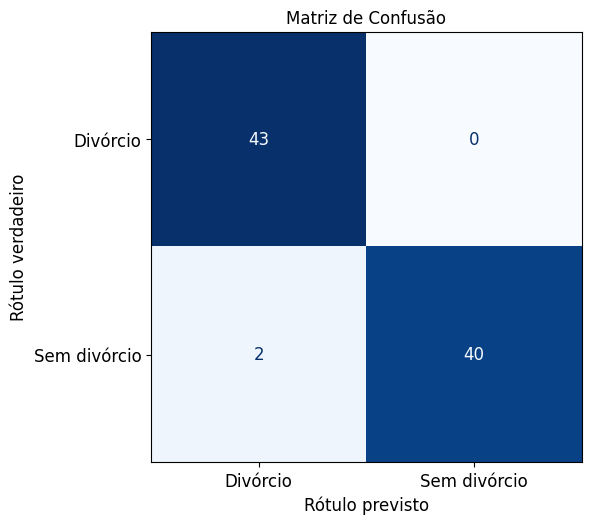

In [ ]:
plot_confusion_matrix(y_pred, y_test,labels=label_names)

### **Avaliação do Random Forest**

In [ ]:
#%% predição nos dados de teste
y_pred = best_model_rf.predict(X_test)

In [ ]:
print('classifiation report')
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_pred, y_test, target_names=label_names, digits=3))

classifiation report
Acurácia: 0.9764705882352941
              precision    recall  f1-score   support

    Divórcio      1.000     0.956     0.977        45
Sem divórcio      0.952     1.000     0.976        40

    accuracy                          0.976        85
   macro avg      0.976     0.978     0.976        85
weighted avg      0.978     0.976     0.976        85



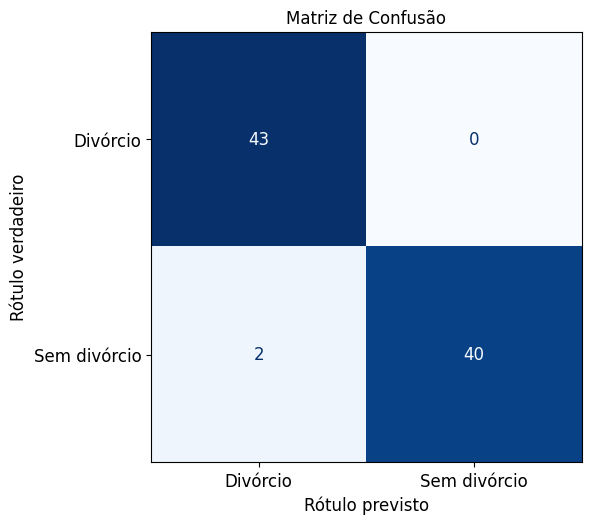

In [ ]:
plot_confusion_matrix(y_pred, y_test,labels=label_names)

### **Avaliação do SVM**

In [ ]:
#%% predição nos dados de teste
y_pred = best_model_svm.predict(X_test)

In [ ]:
print('classifiation report')
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_pred, y_test, target_names=label_names, digits=3))

classifiation report
Acurácia: 0.9764705882352941
              precision    recall  f1-score   support

    Divórcio      1.000     0.956     0.977        45
Sem divórcio      0.952     1.000     0.976        40

    accuracy                          0.976        85
   macro avg      0.976     0.978     0.976        85
weighted avg      0.978     0.976     0.976        85



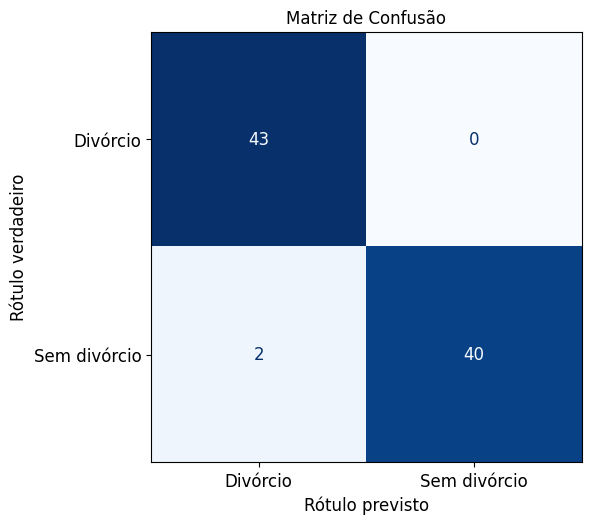

In [ ]:
plot_confusion_matrix(y_pred, y_test,labels=label_names)

### **Avaliação do MLP**

In [ ]:
#%% predição nos dados de teste
y_pred = best_model_ann.predict(X_test)

In [ ]:
print('classifiation report')
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_pred, y_test, target_names=label_names, digits=3))

classifiation report
Acurácia: 0.9764705882352941
              precision    recall  f1-score   support

    Divórcio      1.000     0.956     0.977        45
Sem divórcio      0.952     1.000     0.976        40

    accuracy                          0.976        85
   macro avg      0.976     0.978     0.976        85
weighted avg      0.978     0.976     0.976        85



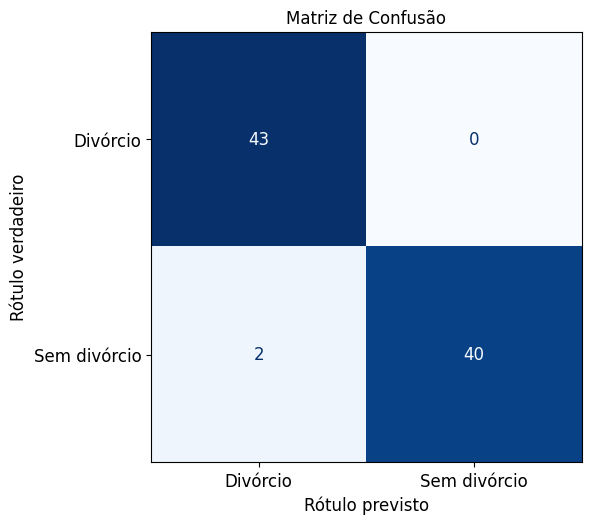

In [ ]:
plot_confusion_matrix(y_pred, y_test,labels=label_names)

### **Avaliação do XGBoost**

In [ ]:
#%% predição nos dados de teste
y_pred = best_model_xgb.predict(X_test)

In [ ]:
print('classifiation report')
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_pred, y_test, target_names=label_names, digits=3))

classifiation report
Acurácia: 0.9647058823529412
              precision    recall  f1-score   support

    Divórcio      0.977     0.955     0.966        44
Sem divórcio      0.952     0.976     0.964        41

    accuracy                          0.965        85
   macro avg      0.965     0.965     0.965        85
weighted avg      0.965     0.965     0.965        85



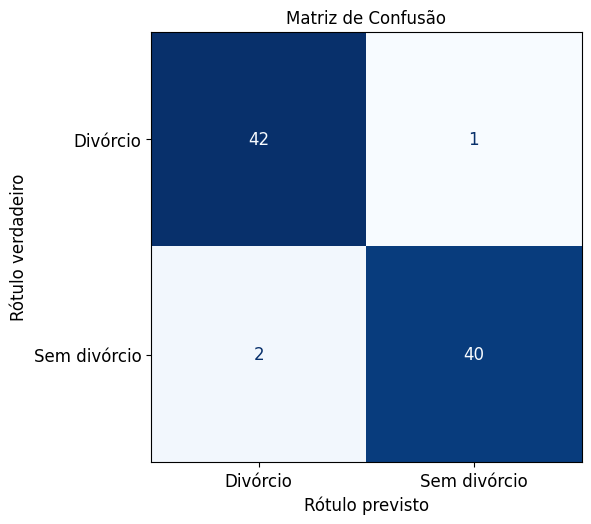

In [ ]:
plot_confusion_matrix(y_pred, y_test,labels=label_names)

# **Etapa 6: Explicação GLOBAL dos modelos com SHAP**

In [ ]:
# --- 1. Definir sementes de aleatoriedade no início ---
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)


## **Explicação do modelo SVM**

  0%|          | 0/85 [00:00<?, ?it/s]

/tmp/ipython-input-37-3012688195.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


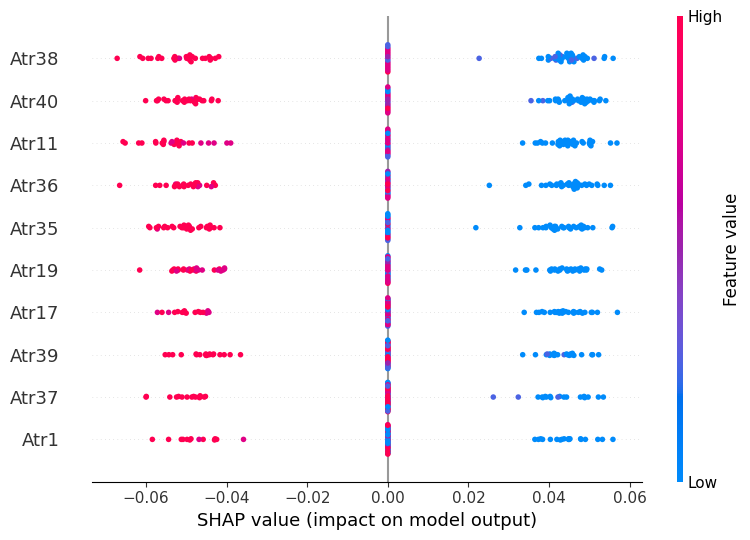

/tmp/ipython-input-37-3012688195.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


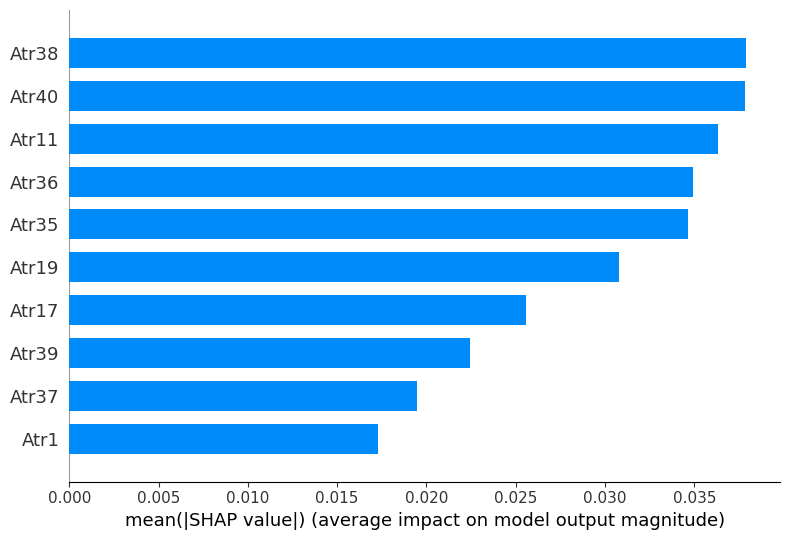

In [ ]:
# 🔷 SHAP com KernelExplainer
sample_X_svm = X_train.sample(n=min(100, X_train.shape[0]), random_state=random_seed) # Use X_train, não X completo para o background
explainer_svm = shap.KernelExplainer(best_model_svm.predict_proba, sample_X_svm, seed=random_seed) # Adiciona a seed aqui!
shap_values_svm = explainer_svm.shap_values(sample_X_svm)

# 📊 Beeswarm plot – SVM
shap.summary_plot(
    shap_values_svm[:, :, 0],  # classe Divorcio
    sample_X_svm,
    plot_type="dot",
    max_display=10
)

# 📊 Summary em barras – SVM
shap.summary_plot(
    shap_values_svm[:, :, 0],
    sample_X_svm,
    plot_type="bar",
    max_display=10
)

## **Explicação do modelo Random Forest**

/tmp/ipython-input-38-2279501478.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Beeswarm Plot (Classe 0 - Casado)


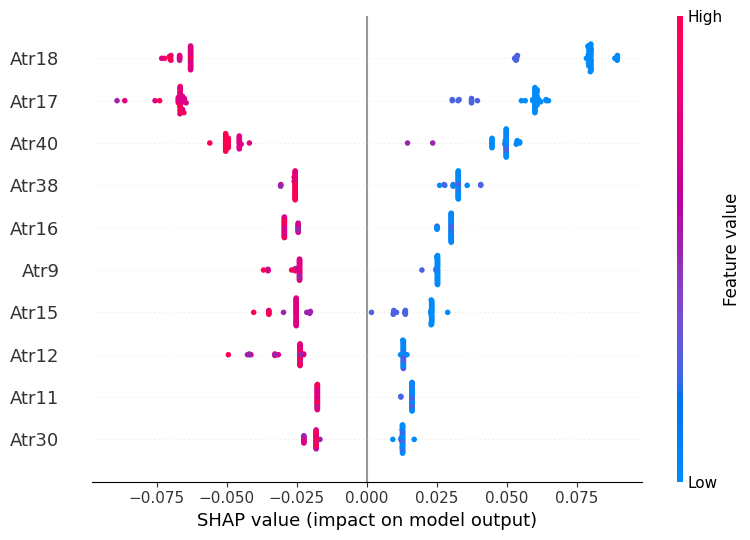


Bar Plot (Classe 0 - Casado)


/tmp/ipython-input-38-2279501478.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


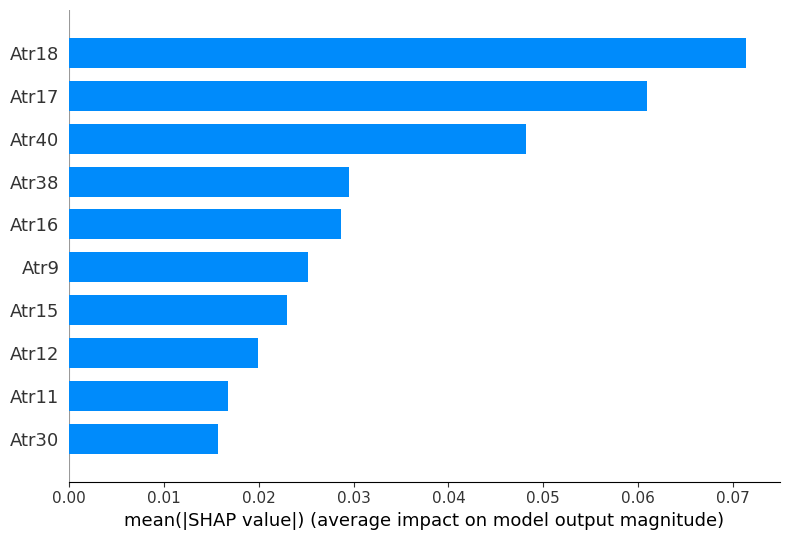

In [ ]:
# 🔷 SHAP com TreeExplainer para Random Forest
explainer_rf = shap.TreeExplainer(best_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test) # Calcular SHAP para X_test

print("Beeswarm Plot (Classe 0 - Casado)")
shap.summary_plot(
    shap_values_rf[:, :, 0],
    X_test,
    plot_type="dot",
    max_display=10
)

print("\nBar Plot (Classe 0 - Casado)")
shap.summary_plot(
    shap_values_rf[:, :, 0],
    X_test,
    plot_type="bar",
    max_display=10,
)

## **Explicação do modelo NB**



  0%|          | 0/85 [00:00<?, ?it/s]

/tmp/ipython-input-39-741592802.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


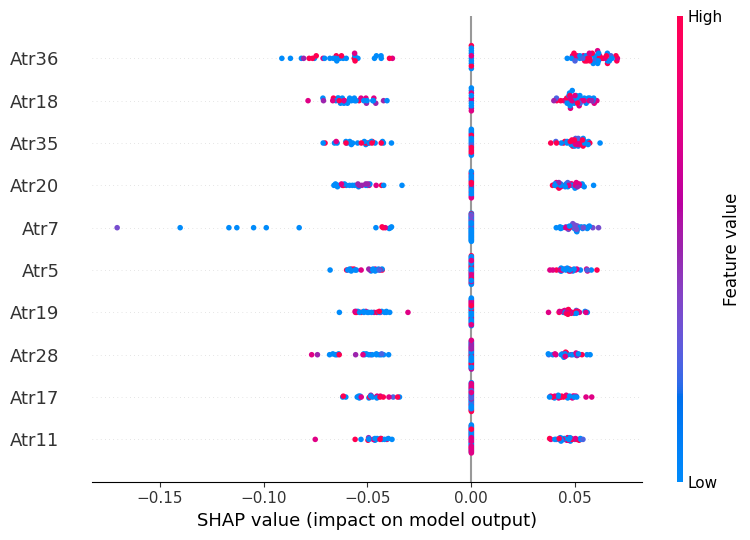

/tmp/ipython-input-39-741592802.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


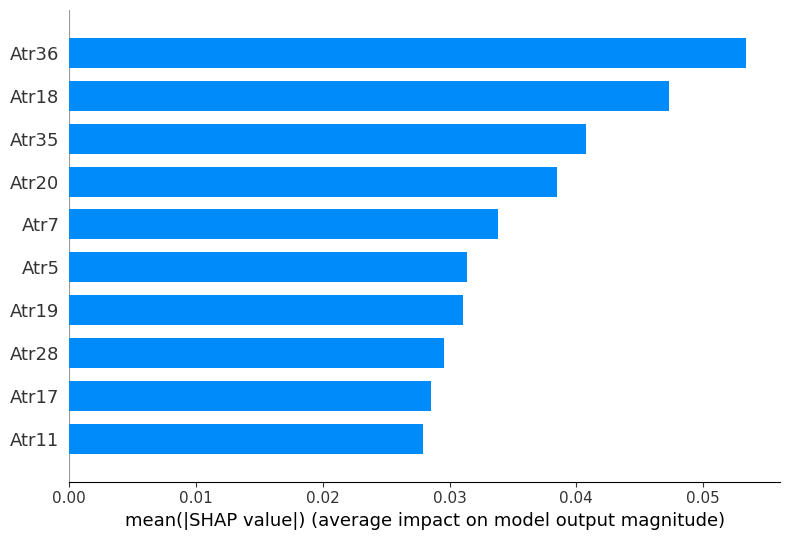

In [ ]:
# 🔷 SHAP com KernelExplainer

sample_X_nb = X_train.sample(n=min(100, X_train.shape[0]), random_state=random_seed)
explainer_nb = shap.KernelExplainer(best_model_nb.predict_proba, sample_X_nb, seed=random_seed) # Adiciona a seed!
shap_values_nb = explainer_nb.shap_values(X_test)

# 📊 Beeswarm plot – NB
shap.summary_plot(
    shap_values_nb[:, :, 0],
    sample_X_nb,
    plot_type="dot",
    max_display=10
)

# 📊 Summary plot em barras – NB
shap.summary_plot(
    shap_values_nb[:, :, 0],
    sample_X_nb,
    plot_type="bar",
    max_display=10
)

## **Explicação do modelo MLP**

  0%|          | 0/85 [00:00<?, ?it/s]

/tmp/ipython-input-40-2018170496.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


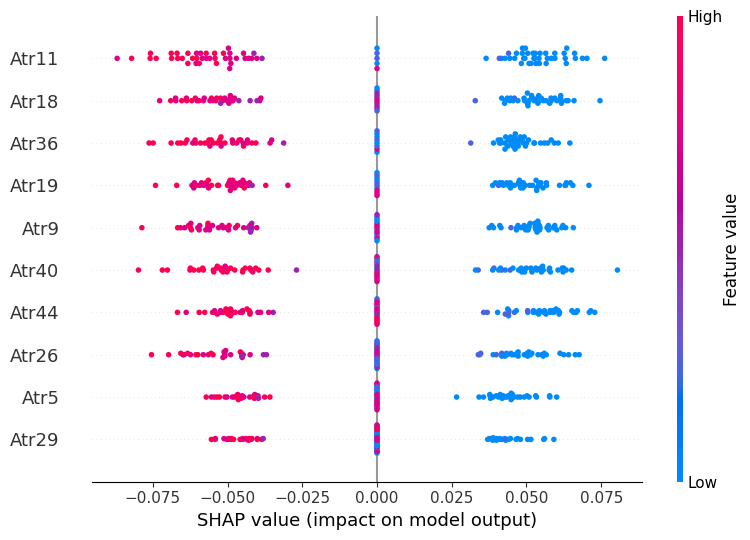

/tmp/ipython-input-40-2018170496.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


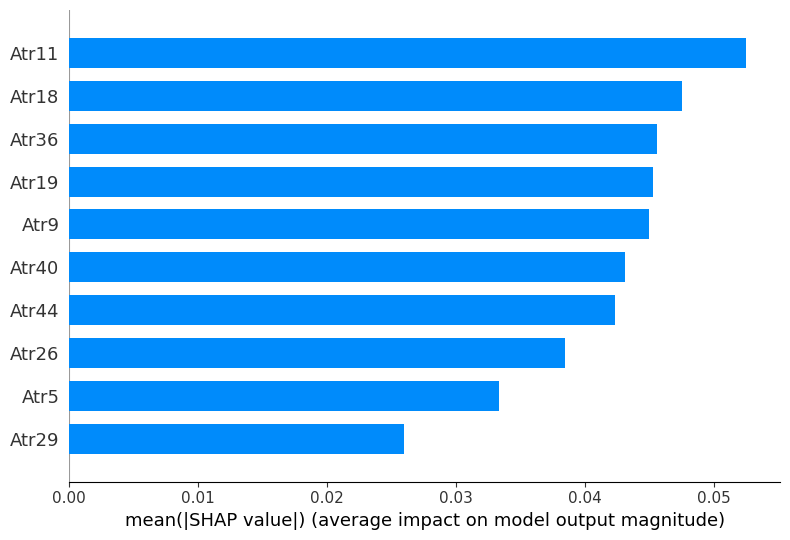

In [ ]:
# 🔷 SHAP com KernelExplainer
sample_X_ann = X_train.sample(n=min(100, X_train.shape[0]), random_state=random_seed)
explainer_ann = shap.KernelExplainer(best_model_ann.predict_proba, sample_X_ann, seed=random_seed) # Adiciona a seed!
shap_values_ann = explainer_ann.shap_values(sample_X_ann)

# 📊 Beeswarm plot – MLP
shap.summary_plot(
    shap_values_ann[:, :, 0],
    sample_X_ann,
    plot_type="dot",
    max_display=10
)

# 📊 Summary em barras – MLP
shap.summary_plot(
    shap_values_ann[:, :, 0],
    sample_X_ann,
    plot_type="bar",
    max_display=10
)


# **Etapa 7: Explicação LOCAL dos modelos com LIME e SHAP**

## **Identificar erros**

In [ ]:
def get_all_misclassified_samples(models, model_names, X_test, y_test):
    import pandas as pd

    # Resetar índices para garantir que a posição seja sequencial
    X_test_reset = X_test.reset_index(drop=False)  # manter o índice original em uma coluna
    y_test_reset = y_test.reset_index(drop=True)

    resultados = []

    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)

        mask_erro = y_pred != y_test_reset

        df_erro = X_test_reset[mask_erro].copy()
        df_erro["Valor Real"] = y_test_reset[mask_erro].values
        df_erro["Predito"] = y_pred[mask_erro]
        df_erro["Modelo"] = name
        df_erro["Posição no X_test"] = df_erro.index  # <- ISSO é o que você usará com iloc
        df_erro.rename(columns={"index": "Índice Original"}, inplace=True)

        resultados.append(df_erro)

    df_resultado = pd.concat(resultados, axis=0)
    colunas_ordem = ["Modelo", "Índice Original", "Posição no X_test", "Valor Real", "Predito"] + list(X_test.columns)
    return df_resultado[colunas_ordem].reset_index(drop=True)



In [ ]:
modelos = [
    best_model_nb,
    best_model_rf,
    best_model_svm,
    best_model_ann,
    best_model_xgb
]

nomes_modelos = [
    "Naive Bayes",
    "Random Forest",
    "SVM",
    "MLP",
    "XGBoost"
]

df_erros_gerais = get_all_misclassified_samples(modelos, nomes_modelos, X_test, y_test)
print(df_erros_gerais)


           Modelo  Índice Original  Posição no X_test  Valor Real  Predito  \
0     Naive Bayes                1                 11           1        0   
1     Naive Bayes                5                 78           1        0   
2   Random Forest                1                 11           1        0   
3   Random Forest                5                 78           1        0   
4             SVM                1                 11           1        0   
5             SVM                5                 78           1        0   
6             MLP                1                 11           1        0   
7             MLP                5                 78           1        0   
8         XGBoost              162                  2           0        1   
9         XGBoost                1                 11           1        0   
10        XGBoost                5                 78           1        0   

    Atr1  Atr2  Atr3  Atr4  Atr5  ...  Atr45  Atr46  Atr47  Atr

## **Explicabilidade local das amostras incorretas com LIME**

In [ ]:
def explicar_erros_com_lime_df(df_erros_gerais, modelo_nome, modelo, X_train, X_test, class_names):

    # Filtrar apenas os erros do modelo específico
    erros_modelo = df_erros_gerais[df_erros_gerais["Modelo"] == modelo_nome]

    if erros_modelo.empty:
        print(f"✅ Nenhum erro de classificação para o modelo: {modelo_nome}")
        return

    print(f"\n📊 Gerando explicações LIME para os erros do modelo: {modelo_nome}")

    # Inicializa o explicador LIME
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        class_names=class_names,
        mode='classification',
        discretize_continuous=True,
        random_state=random_seed
    )

    # Loop pelos erros
    for _, linha in erros_modelo.iterrows():
        pos = int(linha["Posição no X_test"])

        real_idx = int(linha["Valor Real"])
        pred_idx = int(linha["Predito"])

        print(f"\n🔍 Amostra na posição {pos} | Índice original: {linha['Índice Original']}")
        print(f"➡️ Valor real: {real_idx} ({class_names[real_idx]}) | Valor predito: {pred_idx} ({class_names[pred_idx]})")


        # Explica a amostra
        exp = explainer.explain_instance(
            data_row=X_test.iloc[pos],
            predict_fn=modelo.predict_proba
        )
        exp.show_in_notebook(show_table=True)


In [ ]:
# Passo 1: Obter os erros de todos os modelos
df_erros_gerais = get_all_misclassified_samples(
    models=[best_model_rf, best_model_nb, best_model_svm, best_model_xgb, best_model_ann],
    model_names=["RF", "NB", "SVM", "XGBoost", "MLP"],
    X_test=X_test,
    y_test=y_test
)

# Passo 2: Gerar as explicações LIME para um modelo específico (ex: RF)
explicar_erros_com_lime_df(
    df_erros_gerais=df_erros_gerais,
    modelo_nome="RF",
    modelo=best_model_rf,
    X_train=X_train,
    X_test=X_test,
    class_names=["Divórcio", "Sem divórcio"]
)



📊 Gerando explicações LIME para os erros do modelo: RF

🔍 Amostra na posição 11 | Índice original: 1
➡️ Valor real: 1 (Sem divórcio) | Valor predito: 0 (Divórcio)


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 Amostra na posição 78 | Índice original: 5
➡️ Valor real: 1 (Sem divórcio) | Valor predito: 0 (Divórcio)


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

## **Force Plot - SHAP**


🔍 Force plot para amostra na posição 11 do X_test


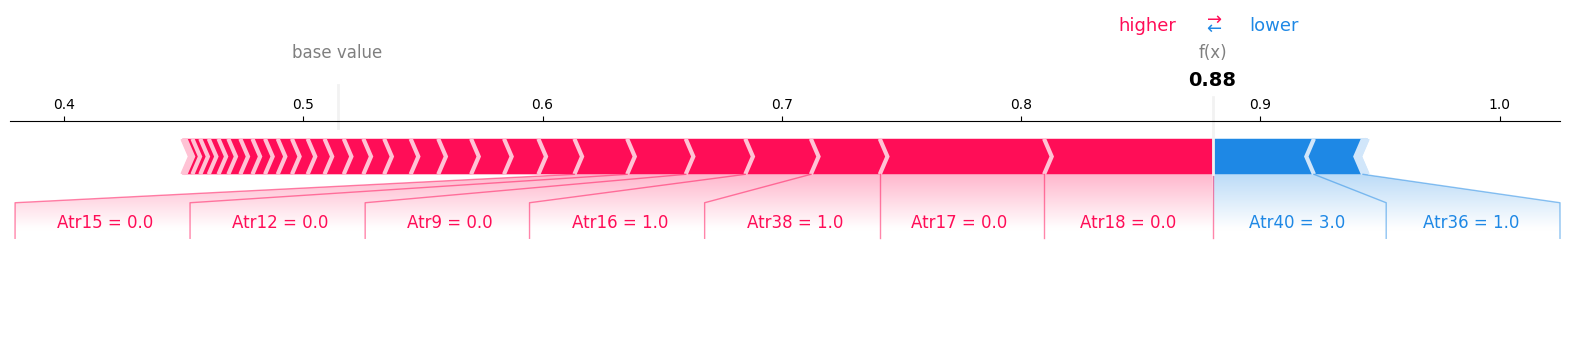

None


🔍 Force plot para amostra na posição 78 do X_test


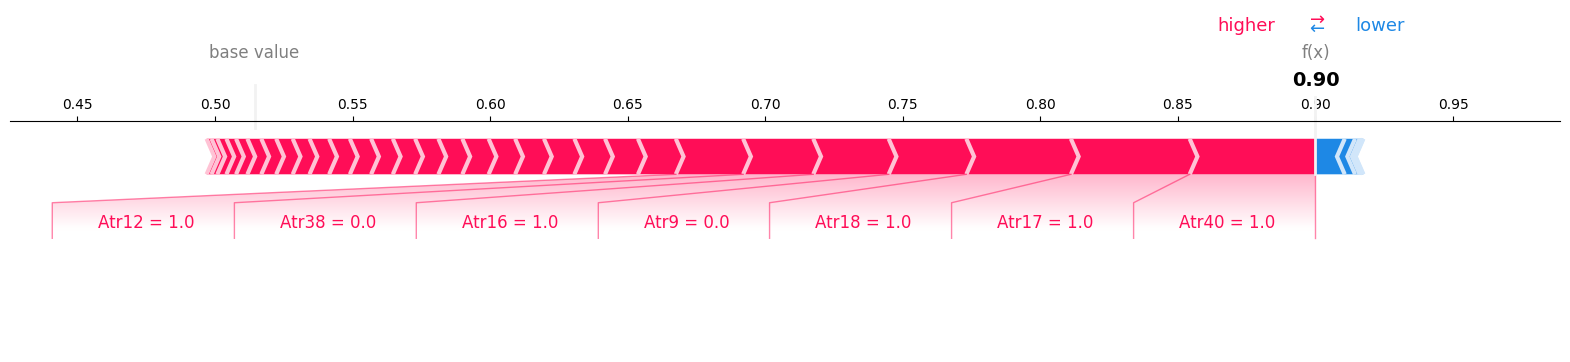

None

In [ ]:

# Coloque os índices das amostras que deram erro no X_test
posicoes_erro = [8, 19]  # posições dentro do X_test 80/20
posicoes_erro = [11, 78]  # posições dentro do X_test 50/50

# TreeExplainer para Random Forest e XGBoost --> Altere as variaveis para o modelo que quer usar
sample_X_rf = shap.sample(X_test, 100, random_state=42)  # opcional: amostra para baseline
explainer_rf = shap.TreeExplainer(best_model_rf, data=sample_X_rf)


# 🔁 Loop para explicar as duas amostras
for pos in posicoes_erro:
    print(f"\n🔍 Force plot para amostra na posição {pos} do X_test")
    amostra = X_test.iloc[[pos]]  # mantém como DataFrame

    shap_values = explainer_rf.shap_values(amostra)

    # 🎯 Mostra o force plot para a classe 0 (Divorciado)
    display(shap.force_plot(
        explainer_rf.expected_value[0],        # valor esperado para a classe 0 (divorcio)
        shap_values[:, :, 0],                  # valores SHAP para a classe 0 (divorcio)
        amostra,
        feature_names=X.columns.tolist(),
        matplotlib=True
    ))
